# Chargement des données

Les données complètes sont disponibles sur le site http://jmcauley.ucsd.edu/data/amazon/links.html. Pour commencer, on se concentre sur des bases de données pour des catégories spécifiques de produit, afin d'avoir une taille raisonnable.

In [23]:
import os
import json
import gzip
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import statistics as stat
from io import StringIO
import nltk
import sklearn

Tout d'abord, on sélectionne la catégorie de produit à étudier:

In [24]:
category_options={
    "Musical Instruments": "reviews_Musical_Instruments.json.gz",
    "Baby": "reviews_Baby.json.gz",
    "Movies and TV": "reviews_Movies_and_TV.json.gz",
}
dropdown = widgets.Dropdown(options=category_options, description="Catégorie de produit à étudier")
display(dropdown)

Ensuite, on décompresse le fichier pour obtenir un fichier en format json

In [25]:
if(not(os.path.isfile(dropdown.value[:-3]))):
    inputFile = gzip.open(dropdown.value, 'rb')
    outputFile = open(dropdown.value[:-3], 'wb')
    outputFile.write(inputFile.read())
    inputFile.close()
    outputFile.close()

On la transforme en Pandas DataFrame 

In [26]:
data=[]
filepath=dropdown.value[:-3]
with open(filepath) as f:
    for line in f:
        data.append(json.loads(line))
df=pd.DataFrame(data)

In [27]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0006428320,"[0, 0]",3,The portfolio is fine except for the fact that...,"03 11, 2014",A1YS9MDZP93857,John Taylor,Parts missing,1394496000
1,0014072149,"[0, 0]",5,If you are a serious violin student on a budge...,"06 6, 2013",A3TS466QBAWB9D,Silver Pencil,"Perform it with a friend, today!",1370476800
2,0041291905,"[0, 0]",5,This is and excellent edition and perfectly tr...,"10 14, 2013",A3BUDYITWUSIS7,joyce gabriel cornett,Vivalldi's Four Seasons,1381708800
3,0041913574,"[0, 0]",5,Perfect for someone who is an opera fan or a w...,"09 23, 2010",A19K10Z0D2NTZK,TexasCowboy,Full score: voice and orchestra,1285200000
4,0201891859,"[0, 1]",1,How many Nocturnes does it contain? All of the...,"10 17, 2012",A14X336IB4JD89,dfjm53,Unable to determine contents,1350432000


# Séparation Training and Validation sets

Avant de commencer toute analyse ou modélisation, il faut séparer l'échantillon d'entrainement et l'échantillon de validation. On procède comme suit:

In [28]:
from sklearn.cross_validation import train_test_split
y = df["overall"]
X = df.drop("overall",axis=1,inplace=False)
X_train,X_test,y_train,y_test = train_test_split(X.index,y,test_size=0.2)
df_train=pd.concat([X,y],axis=1).iloc[X_train] # return dataframe train
df_test=pd.concat([X,y],axis=1).iloc[X_test] # return dataframe test
print(df_train.shape, df_test.shape)

(400146, 9) (100037, 9)


# Analyse descriptive

Regardons la structure de la table:

In [31]:
df_train.head()

,asin,helpful,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,overall
330832,B003VWJ2K8,"[0, 0]",I didn't realize I didn't need a tuner when I ...,"03 30, 2014",A17C4LDRSLHS24,"Susan L. Rhudy ""SR""",The FG700S Yamaha came with a tuner but I real...,1396137600,5
59651,B0002F585K,"[2, 2]","Its a great fork for tuning with an amp, but w...","10 12, 2012",ASST5ZKL21LXJ,fender07,ok but can be better,1350000000,3
36349,B0002D0CIK,"[0, 0]","Not too thick, not too thin (for me). Great fo...","07 6, 2014",A30ZB3Q3G0IPAK,Jeffrey Frank,"Great thickness, great quality.",1404604800,5
261055,B0020M8FDU,"[3, 4]",4/29/12- I purchased a used Galveston Stratoc...,"04 28, 2012",A31GQ2U36G30IG,"Guitartec ""DBF""",CLEARLY A STRAT COPY,1335571200,3
476625,B00D69U1B0,"[1, 1]",This freaking adapter broke down in the first ...,"08 27, 2013",A17PUUKO53QBMM,Ramn Zavala,Very Weak & Poor Design,1377561600,1


Etudions les dimensions clés de la table:

In [32]:
Nbreviews=len(df_train)
Nbproducts=len(set(df_train["asin"]))
Nbreviewers=len(set(df_train["reviewerID"]))
print("Le nombre total de reviews est: "+str(Nbreviews))
print("Le nombre total de produits est: "+str(Nbproducts))
print("Le nombre total de reviewers est: "+str(Nbreviewers))
print("Soit un nombre moyen de "+str(round(Nbreviews/Nbproducts,1))+ " reviews par produit")
print("Soit un nombre moyen de "+str(round(Nbreviews/Nbreviewers,1))+ " reviews par reviewers")

Le nombre total de reviews est: 400146
Le nombre total de produits est: 74984
Le nombre total de reviewers est: 283615
Soit un nombre moyen de 5.3 reviews par produit
Soit un nombre moyen de 1.4 reviews par reviewers


Analysons la distribution des notes des reviews

count    400146.00
mean          4.24
std           1.20
min           1.00
25%           4.00
50%           5.00
75%           5.00
max           5.00
Name: overall, dtype: float64


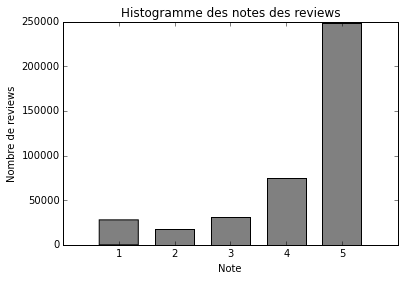

In [33]:
print(df_train["overall"].describe().round(2))
%matplotlib inline 
a=[int(i) for i in df_train["overall"]]
bins=range(1,7)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
ax.set_xticks(bins[:-1])
plt.title("Histogramme des notes des reviews");
plt.xlabel("Note");
plt.ylabel("Nombre de reviews");

Regardons la distribution des notes moyennes par produit. On constate que la distribution est moins "skewed" que précedemment.

count    74984.00
mean         4.23
std          1.00
min          1.00
25%          4.00
50%          4.57
75%          5.00
max          5.00
Name: overall, dtype: float64


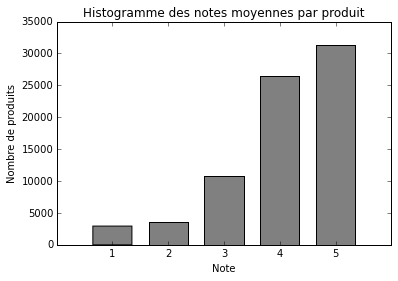

In [34]:
average_note_byproduct=df_train[["asin","overall"]].groupby("asin", as_index=False).mean()
print(average_note_byproduct["overall"].describe().round(2))
%matplotlib inline 
bins=range(1,7)
fig, ax = plt.subplots(1,1)
ax.hist(average_note_byproduct["overall"], bins=bins, align='left', color="grey", rwidth=0.7)
ax.set_xticks(bins[:-1])
plt.title("Histogramme des notes moyennes par produit");
plt.xlabel("Note");
plt.ylabel("Nombre de produits");

Regardons la distribution du nombre de reviews par utilisateur.

count    283615.00
mean          1.41
std           2.06
min           1.00
25%           1.00
50%           1.00
75%           1.00
max         394.00
dtype: float64


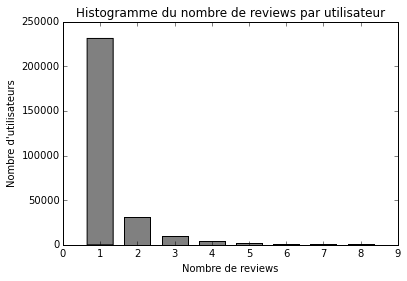

In [35]:
import collections
Nbreview_by_user=collections.Counter(df_train["reviewerID"])
print(pd.Series(Nbreview_by_user).describe().round(2))
bins=range(1,10,1)
a = np.clip(list(Nbreview_by_user.values()), 1, 10)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
plt.title("Histogramme du nombre de reviews par utilisateur");
plt.xlabel("Nombre de reviews");
plt.ylabel("Nombre d'utilisateurs");

Définissons la fonction de comptage du nombre de mots d'une review et appliquons la à nos données

In [36]:
def countWords(review):
    return(len(review.split()))

In [37]:
df_train["countWordsReview"] = df_train["reviewText"].apply(countWords)
df_test["countWordsReview"] = df_test["reviewText"].apply(countWords)
df_train["countWordsSummary"] = df_train["summary"].apply(countWords)
df_test["countWordsSummary"] = df_test["summary"].apply(countWords)

Regardons la distribution du nombre de mots des reviews

In [38]:
print(df_train["countWordsReview"].describe().round(2))

count    400146.00
mean         88.02
std         119.96
min           0.00
25%          28.00
50%          49.00
75%          99.00
max        5977.00
Name: countWordsReview, dtype: float64


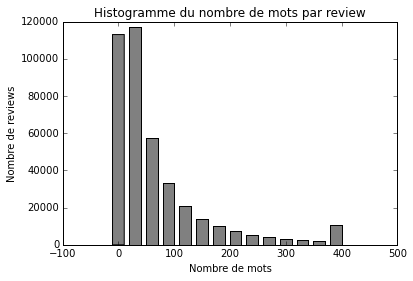

In [39]:
%matplotlib inline 
bins=range(0,430,30)
a = np.clip(df_train["countWordsReview"], 0, 400)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
plt.title("Histogramme du nombre de mots par review");
plt.xlabel("Nombre de mots");
plt.ylabel("Nombre de reviews");

Maintenant regardons plus spécifiquement entre 0 et 100 mots

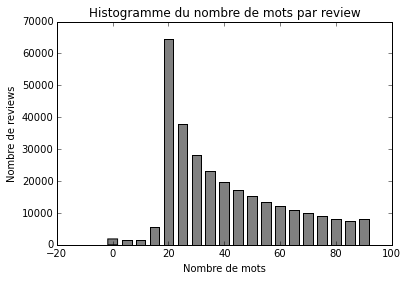

In [46]:
a = [s for s in df_train["countWordsReview"] if s < 101]
%matplotlib inline 
bins=range(0,100,5)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
plt.title("Histogramme du nombre de mots par review");
plt.xlabel("Nombre de mots");
plt.ylabel("Nombre de reviews");

In [15]:
#buf = StringIO()
#for i in range(df.shape[0]):
    #buf.write(df["reviewText"][i])

En dernière étape, nous allons créer des variables pour le mois et le jour de la review, ce qui peut influencer la note.

In [47]:
from datetime import datetime
df_train["Month"] = df_train["unixReviewTime"].apply(lambda x: datetime.strftime(datetime.fromtimestamp(x),'%m')).astype('category')
df_test["Month"] = df_test["unixReviewTime"].apply(lambda x: datetime.strftime(datetime.fromtimestamp(x),'%m')).astype('category')
df_train["Month"].head()

330832    03
59651     10
36349     07
261055    04
476625    08
Name: Month, dtype: category
Categories (12, object): [01, 02, 03, 04, ..., 09, 10, 11, 12]

In [48]:
df_train["Weekday"] = df_train["unixReviewTime"].apply(lambda x: datetime.strftime(datetime.fromtimestamp(x),'%a')).astype('category')
df_test["Weekday"] = df_test["unixReviewTime"].apply(lambda x: datetime.strftime(datetime.fromtimestamp(x),'%a')).astype('category')
df_train["Weekday"].head()

330832    Sun
59651     Fri
36349     Sun
261055    Sat
476625    Tue
Name: Weekday, dtype: category
Categories (7, object): [Fri, Mon, Sat, Sun, Thu, Tue, Wed]

# Préparation des données

On prépare les données en utilisant la fonction `TfidfVectorizer` du package `sklearn`. Notons que nous utilisons les stopwords donnés par `nltk` pour réduire le nombre de mots.

In [120]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
tfidf_vect = TfidfVectorizer()
tfidf_vect_stopword = TfidfVectorizer(stop_words= stopwords.words('english'))

### 1. Pour le texte complet de la review

a. Echantillon Train

In [123]:
corpus_train_reviewText=list(df_train["reviewText"])
X_train_tfidf_reviewText = tfidf_vect_stopword.fit_transform(corpus_train_reviewText)
X_train_tfidf_reviewText.shape

(400146, 220020)

In [51]:
#X_train_tfidf_reviewText = tfidf_vect.fit_transform(corpus_reviewText)
#X_train_tfidf_reviewText.shape

b. Echantillon Test

In [124]:
corpus_test_reviewText=list(df_test["reviewText"])
X_test_tfidf_reviewText = tfidf_vect_stopword.transform(corpus_test_reviewText)
X_test_tfidf_reviewText.shape

(100037, 220020)

### 2. Pour le résumé de la review

a. Echantillon Train

In [125]:
corpus_train_summary=list(df_train["summary"])
X_train_tfidf_summary = tfidf_vect_stopword.fit_transform(corpus_train_summary)
X_train_tfidf_summary.shape

(400146, 42014)

b. Echantillon Test

In [126]:
corpus_test_summary=list(df_test["summary"])
X_test_tfidf_summary = tfidf_vect_stopword.transform(corpus_test_summary)
X_test_tfidf_summary.shape

(100037, 42014)

### 3. Pour les autres features du dataframe

a. Echantillon Train

In [127]:
X_train_countWords=df_train[["countWordsReview","countWordsSummary"]].astype(int)
X_train_dates=df_train[["Month","Weekday"]]
X_train_otherfeatures=df_train[["countWordsReview","countWordsSummary","Month","Weekday"]]
print(X_train_countWords.shape, X_train_dates.shape, X_train_otherfeatures.shape)

(400146, 2) (400146, 2) (400146, 4)


b. Echantillon Test

In [128]:
X_test_countWords=df_test[["countWordsReview","countWordsSummary"]].astype(int)
X_test_dates=df_test[["Month","Weekday"]]
X_test_otherfeatures=df_test[["countWordsReview","countWordsSummary","Month","Weekday"]]
print(X_test_countWords.shape, X_test_dates.shape, X_test_otherfeatures.shape)

(100037, 2) (100037, 2) (100037, 4)


### 4. Combinaison des features

In [129]:
# A possible approach that would require to construct pipelines
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import HashingVectorizer
hash_vect = HashingVectorizer()

ImportError: cannot import name 'HashingVectorizer'

In [130]:
from sklearn.feature_extraction import DictVectorizer
dic_vec = DictVectorizer()

a. Echantillon Train

In [131]:
from scipy.sparse import hstack
X_train_alltext=hstack([X_train_tfidf_reviewText, X_train_tfidf_summary])
print(X_train_alltext.shape)

(400146, 262034)


In [132]:
X_train_textwordcount=hstack([X_train_tfidf_reviewText, X_train_tfidf_summary,X_train_countWords.astype(int)])
X_train_textandwordcount.shape

(400146, 262036)

In [133]:
dic_train_weekdays = pd.DataFrame(X_train_otherfeatures["Weekday"]).to_dict('records')
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()
X_train_weekdays = vec.fit_transform(dic_train_weekdays)
X_train_weekdays.shape

(400146, 7)

In [134]:
X_train_textandwordcountandweekdays = hstack([X_train_textandwordcount, X_train_weekdays])
print(X_train_textandwordcountandweekdays.shape)

(400146, 262043)


In [135]:
dic_train_months = pd.DataFrame(X_train_otherfeatures["Month"]).to_dict('records')
vec = DictVectorizer()
X_train_months = vec.fit_transform(dic_train_months)

In [136]:
X_train_all = hstack([X_train_textandwordcountandweekdays, X_train_months])
print(X_train_all.shape)

(400146, 262055)


In [153]:
X_train_supvariables = hstack([X_train_countWords.astype(int), X_train_weekdays, X_train_months])
print(X_train_supvariables.shape)

(400146, 21)


b. Echantillon Test

In [137]:
X_test_alltext=hstack([X_test_tfidf_reviewText, X_test_tfidf_summary])
print(X_test_alltext.shape)

(100037, 262034)


In [138]:
X_test_textandwordcount=hstack([X_test_tfidf_reviewText, X_test_tfidf_summary,X_test_countWords.astype(int)])
X_test_textandwordcount.shape

(100037, 262036)

In [139]:
dic_test_weekdays = pd.DataFrame(X_test_otherfeatures["Weekday"]).to_dict('records')
vec = DictVectorizer()
X_test_weekdays = vec.fit_transform(dic_test_weekdays)
X_test_weekdays.shape

(100037, 7)

In [140]:
X_test_textandwordcountandweekdays = hstack([X_test_textandwordcount, X_test_weekdays])
print(X_test_textandwordcountandweekdays.shape)

(100037, 262043)


In [141]:
dic_test_months = pd.DataFrame(X_test_otherfeatures["Month"]).to_dict('records')
vec = DictVectorizer()
X_test_months = vec.fit_transform(dic_test_months)

In [142]:
X_test_all = hstack([X_test_textandwordcountandweekdays, X_test_months])
print(X_test_all.shape)

(100037, 262055)


In [154]:
X_test_supvariables = hstack([X_test_countWords.astype(int), X_test_weekdays, X_test_months])
print(X_test_supvariables.shape)

(100037, 21)


# Machine Learning

### 1. Pour le texte complet de la review

In [149]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf_reviewText, y_train.astype('category'))
predicted_reviewText = clf.predict(X_test_tfidf_reviewText)

In [77]:
from sklearn.linear_model import SGDClassifier
SGDclass = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=42)
clf2 = SGDclass.fit(X_train_tfidf_reviewText, y_train.astype('category'))
predicted2_reviewText = clf2.predict(X_test_tfidf_reviewText)

### 2. Pour le résumé de la review

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf_summary, y_train.astype('category'))
predicted_summary = clf.predict(X_test_tfidf_summary)

In [ ]:
from sklearn.linear_model import SGDClassifier
SGDclass = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=42)
clf2 = SGDclass.fit(X_train_tfidf_summary, y_train.astype('category'))
predicted2_summary = clf2.predict(X_test_tfidf_summary)

### 3. Résumé + Texte de la review

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_alltext, y_train.astype('category'))
predicted_summary = clf.predict(X_test_tfidf_alltext)

In [ ]:
from sklearn.linear_model import SGDClassifier
SGDclass = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=42)
clf2 = SGDclass.fit(X_train_alltext, y_train.astype('category'))
predicted2_summary = clf2.predict(X_test_tfidf_alltext)

### 4. Uniquement les variables supplémentaires

In [155]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_supvariables, y_train.astype('category'))
predicted_supvariables = clf.predict(X_test_supvariables)

In [ ]:
from sklearn.linear_model import SGDClassifier
SGDclass = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=42)
clf2 = SGDclass.fit(X_train_supvariables, y_train.astype('category'))
predicted2_supvariables = clf2.predict(X_test_supvariables)

### 5. All features

In [67]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_all, y_train.astype('category'))
predicted_all = clf.predict(X_test_all)

In [68]:
from sklearn.linear_model import SGDClassifier
SGDclass = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=42)
clf2 = SGDclass.fit(X_train_all, y_train.astype('category'))
predicted2_all = clf2.predict(X_test_all)

# Evaluation de la performance

### 1. Pour le text complet de la review

In [156]:
np.mean(predicted_summary == y_test)

0.59430010895968488

In [78]:
np.mean(predicted2_reviewText == y_test)

0.62174995251756848

In [152]:
from sklearn import metrics
print(metrics.classification_report(y_test, predicted_reviewText))
print(metrics.confusion_matrix(y_test, predicted_reviewText))

             precision    recall  f1-score   support

        1.0       0.81      0.27      0.41      7003
        2.0       1.00      0.00      0.00      4488
        3.0       0.53      0.02      0.04      7763
        4.0       0.34      0.04      0.07     18803
        5.0       0.65      1.00      0.79     61980

avg / total       0.61      0.65      0.53    100037

[[ 1902     0    18   186  4897]
 [  310     1    77   318  3782]
 [  102     0   166   844  6651]
 [   19     0    39   764 17981]
 [   15     0    13   143 61809]]


In [80]:
from sklearn import metrics
print(metrics.classification_report(y_test, predicted2_reviewText))
print(metrics.confusion_matrix(y_test, predicted2_reviewText))

             precision    recall  f1-score   support

        1.0       0.00      0.00      0.00      7136
        2.0       0.00      0.00      0.00      4443
        3.0       0.00      0.00      0.00      7660
        4.0       0.00      0.00      0.00     18600
        5.0       0.62      1.00      0.77     62198

avg / total       0.39      0.62      0.48    100037

[[    0     0     0     0  7136]
 [    0     0     0     0  4443]
 [    0     0     0     0  7660]
 [    0     0     0     0 18600]
 [    0     0     0     0 62198]]


D:\Users\acombess\PythonENSAE\python\lib\site-packages\sklearn\metrics\classification.py:958: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Then: draw multi class ROC Curve using this example: http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [87]:
for i in range(0,5) :
        print(str(corpus_test_reviewText[i]) +"\n"+ "------ We predict "+ str(predicted_reviewText[i])+"\n")

I bought this for my husband who is learning to play guitar.  It was very affordable for the package deal, and he was excited about it when it arrived in a cool custom box.  But right away, on the first use, the electronic tuner malfunctioned?  causing him to break a string.  Not a big enough complaint to bother returning it though, since he has another higher-end tuner that he prefers anyway.  He replaced the broken strings and hasn't had any problems since then.  He LOVES the little amp, and he can plug his acoustic-electric guitar into it as well.  All in all, a good deal for the price.
------ We predict 5.0

I bought the Pyle-Pro PDWM7300 Rack Mount system based upon the reviews I had read which were mostly favorable. I am a DJ and I have used this system now a couple of times and for what I need it for it has been great. While I use it mostly for talking at DJ events I have used it also for vocals in a live band scenario. In both situations the Pyle system has performed fantastic.

### 2. Pour le résumé de la review

In [ ]:
#A remplir

### 3. Pour la combinaison des features

In [ ]:
#A remplir

# Analyse de la performance en fonction du nombre de mots

In [89]:
def createBins(x):
    if x["countWordsReview"] < 30:
        return(30)
    elif x["countWordsReview"] < 100:
        return(100)
    elif x["countWordsReview"] < 200:
        return(200)
    else:
        return(300)

In [90]:
dfy = pd.DataFrame(y_test)
dfy["predicted"] = predicted_reviewText
dfy["reviewText"] = df_test["reviewText"]
dfy["countWordsReview"] = dfy["reviewText"].apply(countWords)
dfy["summary"] = df_test["summary"]
dfy["countWordsSummary"] = dfy["summary"].apply(countWords)
dfy["qualite"] = abs(predicted_reviewText - y_test)
dfy["bin"] = dfy.apply(createBins, axis = 1)
dfy.head()

,overall,predicted,reviewText,countWordsReview,summary,countWordsSummary,qualite,bin
451424,3,5,I bought this for my husband who is learning t...,108,Pretty good deal,3,2,200
358952,5,5,I bought the Pyle-Pro PDWM7300 Rack Mount syst...,182,Proven to be reliable,4,0,200
262820,4,5,This is a light guitar that's easy to play. Mi...,245,Good guitar with budget tuners,5,1,300
345225,5,5,I bought this for my husband for Christmas and...,25,FANTASTIC,1,0,30
485462,4,5,Would recommend this CD to anyone who likes mo...,80,good CD,2,1,100


In [91]:
np.mean(dfy[dfy.bin==30]["qualite"])

0.592128104297304

In [92]:
sum(abs(predicted_reviewText - y_test))

75948.0

# Bits of useless code (so far)

In [36]:
#an example with another function TfidfVectorizer using frequency instead of count
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = ["This is very strange",
          "This is very nice"]
vectorizer = TfidfVectorizer(min_df=1)
X = vectorizer.fit_transform(corpus)
idf = vectorizer.idf_
print(dict(zip(vectorizer.get_feature_names(), idf)))

{'this': 1.0, 'is': 1.0, 'strange': 1.4054651081081644, 'very': 1.0, 'nice': 1.4054651081081644}


In [127]:
#Meh... Does not work yet
#nltk.download()
#all_words = nltk.FreqDist(w.lower() for w in nltk.word_tokenize(list(df["summary"]))) Does not work yet

- Evaluation de la performance pour les différents blocs de features
- Normalisation du nombre de mots
- Classification binaire + courbe de ROC
- Analyse de la performance en fonction du nombre de mots